In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
from utils.utils import MyDataset, show_image, visualise_output
import sys
sys.path.append("..")
from networks.autoencoder import FireAutoencoder
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy

In [2]:
train_dataset = MyDataset(root='../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [136]:
latent_dims = 256
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
net = FireAutoencoder(capacity, input_size, latent_dims, sigmoid)
net.load_state_dict(torch.load(f'weights/v1//homo_2_sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [137]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [138]:
all_images, all_r = next(iter(full_loader))

In [139]:
embeddings = net.encode(all_images)

In [140]:
with torch.no_grad():
    X, y = embeddings.numpy(), all_r.numpy()

In [141]:
reg = LinearRegression().fit(X, y)

In [142]:
reg.score(X, y)

0.20397886210171057

In [143]:
reg.predict(X)

array([-798.9492 , -743.04926, -777.2674 , ..., -779.8736 , -760.2816 ,
       -763.25116], dtype=float32)

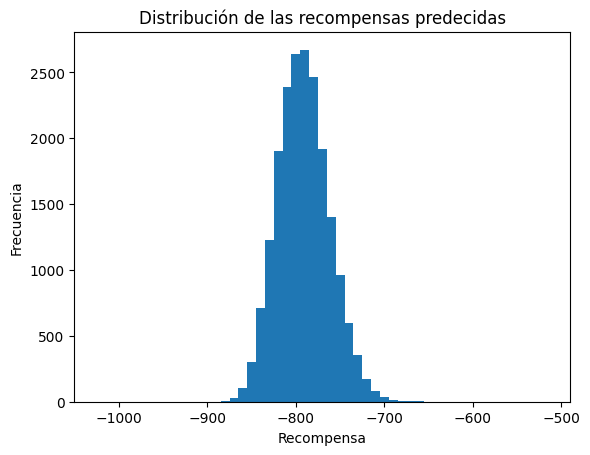

In [144]:
bins = np.arange(-1020, -500, 10)
plt.hist(reg.predict(X), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [145]:
def linear_func(x):
    return -(np.dot(x,reg.coef_) + reg.intercept_)

In [146]:
res = scipy.optimize.minimize(linear_func, x0=np.zeros(latent_dims))

In [147]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -15666125387.185125
        x: [-5.389e+06  1.313e+06 ...  4.184e+06  1.624e+06]
      nit: 1
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 3855
     njev: 15

In [148]:
minimum = torch.from_numpy(res.x)

In [149]:
net.float()

FireAutoencoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [150]:
solution = net.decode(minimum.float().unsqueeze(0))

In [151]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

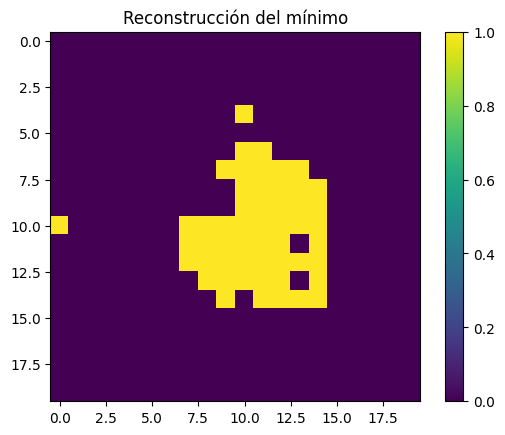

In [152]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.savefig(f"linear_regresion/v1/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [153]:
with torch.no_grad():
    print(solution[0][0].numpy())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.